
# <div style="text-align: center;" markdown="1">Python Project Second Year</div>
***

## <div style="text-align: center;" markdown="1">Predicting a song "popularity" with the Million Song Dataset</div>

***


![alt text](http://static.echonest.com/b/millionsong2.jpg)


# Introduction

The Million Song Dataset was a set created by __LabRosa__ (Laboratory for the Recognition and Organization of Speech and Audio)  for research purposes. It contains information on 1 million song with many parameters. We could not find the complete database but had access to two different datasets for a total of 20,000 songs. Our variable of interest is song popularity that we would like to be able to predict. In the set it is represented as a parameter called "song hotttnesss" it is a number creating using not only song sales but also online popularity, tweets, facebook references, views and so on. While we could use parameters that were used to create this indicator, we will instead try and find if we are able to predict this coefficient using only musical parameters. 

# In other words, is there a recipe for the perfect song ?

### Plan

>## I.  Database Cleaning and Treatments

>## II. Regression Using the GradientBoostingRegressor

>## III. Classification 
>> ### With a simple cross validation
>> ### With several cross validations

>## IV. Logarithmic Transformation and Classification
>> ### Basic Classification
>> ### Let's rock !

# I.  Database Cleaning and Treatments



In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Let's start by creating a function  __get_infos__ that  will recursively collect all the informations inside the folders that contain our songs in h5 format we will need songs titles, artist name, album name to recognize them and also parameters concerning titles themselves : popularity of the song and the artist, "familiarity" which stands for the interactivity of artists with their audience and also music parameters : key, mode, duration, end of fade in, loudness, tempo, time signature and year. 

__If you're testing the code don't run the three following blocks or go get a cup of coffee__

In [ ]:
import os
import glob
import hdf5_getters as hd
import pandas as pd

def get_infos(basedir,ext='.h5'):
    df = []
    i = 0
    for root, dirs, files in os.walk(basedir):
        if i %20 == 0:
            print(i)
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            d = {}
            h5 = hd.open_h5_file_read(f)
            d["nom chanson"] = (hd.get_title(h5))
            d["nom artiste"] = (hd.get_artist_name(h5))
            d["Danceabilité"] = (hd.get_danceability(h5))
            d["Popularité"] = (hd.get_song_hotttnesss(h5))
            d["Popularité artiste"] = hd.get_artist_hotttnesss(h5)
            d["Familiarité"] = hd.get_artist_familiarity(h5)
            d["Clé"] = (hd.get_key(h5))
            d["Durée"] = (hd.get_duration(h5))
            d["Fin du fondu"] = (hd.get_end_of_fade_in(h5))
            d["Energie"] = (hd.get_energy(h5))
            d["Intensité"] = (hd.get_loudness(h5))
            d["Mode"] = (hd.get_mode(h5))
            d["Nom Album"] = (hd.get_release(h5))
            d["Fondu de fin"] = (hd.get_start_of_fade_out(h5))
            d["Tempo"] = (hd.get_tempo(h5))
            d["Signature Temporelle"] = (hd.get_time_signature(h5))
            d["Année"] = (hd.get_year(h5))
            df.append(d)
            h5.close()
        i+=1
    return pd.DataFrame(df)

In [ ]:
df = get_infos("C:\\Users\Enguérand\Documents\ProjetPython2A\dataset\millionsongsubset_full\MillionSongSubset")


In [ ]:
df2 = get_infos("C:\\Users\Enguérand\Documents\ProjetPython2A\dataset\cal10k")

Here we are we now save what we have made into two different datasets.

In [ ]:
df.to_csv("base_de_depart_test.csv",encoding = 'utf-8')
df2.to_csv("base_de_depart_cal_test.csv",encoding = 'utf-8')

# __ START HERE IF YOU ARE TESTING THE CODE__

Now we will begin, we had two datasets with a total of 20 000 song, after getting rid of lines where Popularity = 0 and NA we will fall to 7860.

In [2]:
import pandas as pd
df1= pd.read_csv("base_de_depart_cal_test.csv")
df2 = pd.read_csv("base_de_depart_test.csv")
df = df1.merge(df2, how = 'left')

Let's clean the dataset a bit and look at what we can find inside :

In [3]:
mask = (df['Popularité'] == 0)
df = df.loc[~mask]
df.dropna(inplace=True)
df.describe()

,Unnamed: 0,Année,Clé,Danceabilité,Durée,Energie,Familiarité,Fin du fondu,Fondu de fin,Intensité,Mode,Popularité,Popularité artiste,Signature Temporelle,Tempo
count,7860.000000,7860.000000,7860.000000,7860,7860.000000,7860,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000,7860.000000
mean,4949.080025,1295.288168,5.242112,0,238.900626,0,0.702839,0.731064,229.236373,-11.445964,0.706361,0.348955,0.345650,3.520229,123.981024
std,2854.759618,951.406112,3.546472,0,88.814951,0,0.108695,1.689054,87.296942,5.334093,0.455457,0.218653,0.149665,1.257414,33.906117
min,0.000000,0.000000,0.000000,0,18.833830,0,0.000000,0.000000,18.834000,-40.362000,0.000000,0.007104,0.000000,1.000000,0.000000
25%,2472.750000,0.000000,2.000000,0,180.584040,0,0.651998,0.177000,171.990000,-14.380250,0.000000,0.149819,0.315398,3.000000,97.738500
50%,4946.500000,1986.000000,5.000000,0,223.372610,0,0.716325,0.326000,213.560000,-10.306000,1.000000,0.336133,0.379299,4.000000,120.174000
75%,7419.250000,2002.000000,8.000000,0,274.219952,0,0.776672,0.496000,263.102500,-7.522500,1.000000,0.518408,0.423154,4.000000,145.714000
max,9876.000000,2010.000000,11.000000,0,1234.206890,0,0.902741,35.254000,1225.137000,0.411000,1.000000,0.928940,1.000000,7.000000,253.469000


First we will separate numerical and categorical variables. Since categorical variables are for example "name" we will not need them. We define our target for the regression : Yr and to try to explain it we create the vector X. Yl will be useful later.

In [6]:
import numpy
import numpy as np

numerique = [ c for c,d in zip(df.columns,df.dtypes) if (d == numpy.int64) or (d == numpy.float64) and (c not in ["Popularité","Danceabilité","Energie"]) and (c not in ['Unnamed: 0']) ]
target = "Popularité"
X = df[ numerique[1:11] ]
Yr = df[ target ]
Yl = Yr.apply(lambda r : ((log(r))))

Let's first look at the target form :

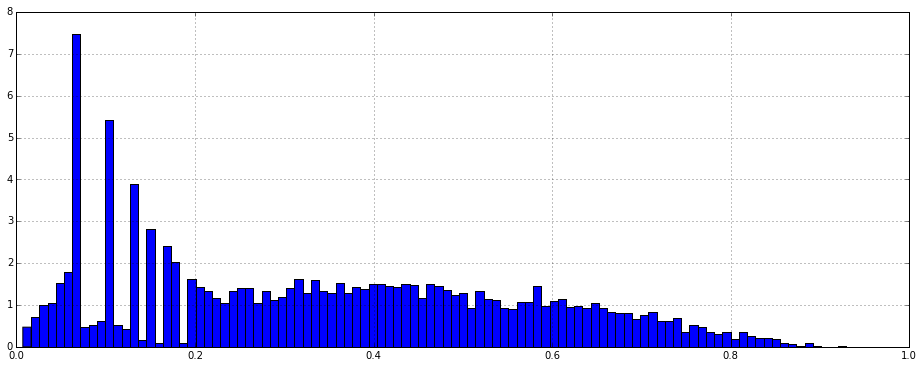

In [8]:
Yr.hist(figsize=(16,6), bins=100, normed = True)
savefig("histo.png")

We have two different patterns : before the mean it looks like there are many "poor popularity songs" all the same popularity, very high with holes in between, after this part there is our target : a long tail of popular songs.

## II. Regression using GradientBoostingRegressor

Let's test our regression model, we started with a __Linear Regression__ and Support __Vector Regression__ with poor results, the best we could get was with a __GradientBoostingRegressor__.

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Yr, test_size=0.4, random_state = 0)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingRegressor



clfr = Pipeline([
      ('normalize', Normalizer()),
      ('regression',GradientBoostingRegressor(random_state = 0))
    ])
clfr = clfr.fit(X_train, Y_train.ravel())

In [12]:
from sklearn import metrics
predicted = clfr.predict(X_test)
expected = Y_test
metrics.explained_variance_score(Y_train, clfr.predict(X_train))

0.47239466995717772

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

RMS: 0.17845850677


C:\Users\Enguérand\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


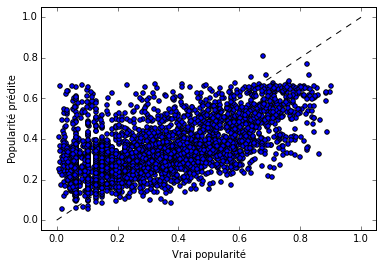

In [14]:
plt.scatter(expected, predicted)
plt.plot([0, 1], [0, 1],'--k')
plt.axis('tight')
plt.xlabel('Vrai popularité')
plt.ylabel('Popularité prédite')
print("RMS:", np.sqrt(np.mean((predicted - expected) ** 2)))

Not really astonishing... Let's try some **feature selection**

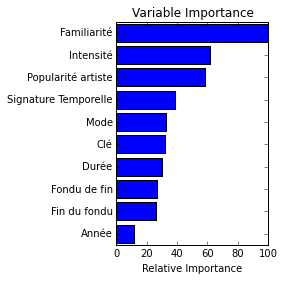

In [15]:
feature_name = X.columns
limit = 5
feature_importance = clfr.named_steps['regression'].feature_importances_[:15]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_name[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

RMS: 0.180287899056


C:\Users\Enguérand\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


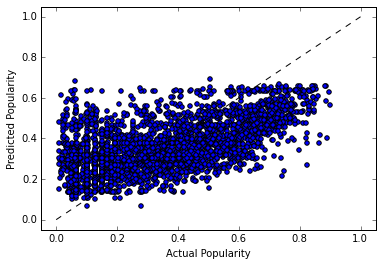

In [16]:
X2 = X[["Familiarité","Popularité artiste","Signature Temporelle","Mode"]]
X_train, X_test, Y_train, Y_test = train_test_split(X2, Yr, test_size=0.4, random_state = 0)
clfr = Pipeline([
      ('normalize', Normalizer()),
      ('regression', GradientBoostingRegressor())
    ])
clfr = clfr.fit(X_train, Y_train.ravel())
predicted = clfr.predict(X_test)
expected = Y_test
plt.scatter(expected, predicted)
plt.plot([0, 1], [0, 1],'--k')
plt.axis('tight')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
print("RMS:", np.sqrt(np.mean((predicted - expected) ** 2)))

savefig("reg.png")

Frankly it is not really going well. But we can at least distinguish once again two categories appearing for the predicted values. We might get luckier when using a classification. __Real-world justification__ : have you ever wondered about the second decimal of an artist popularity ? No, you only wonder about whether or not an artist will be popular.

## III. Classification
### 1. With a single cross-validation

Let's start by splitting Y into 2 categories : less than the median tunes will be __"unpopular"__ and more than the median ones will be __"popular"__.

In [17]:
Y = Yr.apply(lambda r : 1.0 if r >= Yr.median() else 0.0)

And let's classify ! We will use a __Gradient Boosting Classifier__ since we have heterogenous data. 

In [18]:
from sklearn.cross_validation import train_test_split, cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state = 0)

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier

clf = Pipeline([
      ('normalize', Normalizer()),
      ('classifier', GradientBoostingClassifier(random_state = 1))
    ])

clf = clf.fit(X_train, Y_train.ravel())

We will implement confusion matrix

[[1718  619]
 [ 510 1869]]
[[1127  473]
 [ 392 1152]]


C:\Users\Enguérand\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


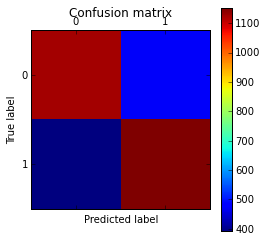

In [50]:
from sklearn.metrics import confusion_matrix
for x,y in [ (X_train, Y_train), (X_test, Y_test) ]:
    yp  = clf.predict(x)
    cm = confusion_matrix(y.ravel(), yp.ravel())
    print(cm)
import matplotlib.pyplot as plt
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
savefig("conf_mat1.png")

Not bad, we have a nice separation between the two classes. We seem to have no overfitting problem since the percentages of accurately classified labeled are almost the same for train and test. Let's observe our first scores :

In [21]:
from sklearn import metrics
print(metrics.classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.72      0.69      0.71      1593
        1.0       0.70      0.73      0.71      1551

avg / total       0.71      0.71      0.71      3144



Even though we are a little bit more precise when classifying type 0 we have roughly the same f1 scores for 0 and 1. Let's now draw these observations graphically.

In [22]:
from sklearn.metrics import roc_curve, auc
probas = clf.predict_proba(X_test)
probas[:5]

array([[ 0.56049106,  0.43950894],
       [ 0.16062409,  0.83937591],
       [ 0.41756436,  0.58243564],
       [ 0.45312314,  0.54687686],
       [ 0.61089524,  0.38910476]])

In [23]:
rep = [ ]
yt = Y_test.ravel()
for i in range(probas.shape[0]):
    p0,p1 = probas[i,:]
    exp = yt[i]
    if p0 > p1 :
        if exp == 0 :
            # bonne réponse
            rep.append ( (1, p0) )
        else :
            # mauvaise réponse
            rep.append( (0,p0) )
    else :
        if exp == 0 :
            # mauvaise réponse
            rep.append ( (0, p1) )
        else :
            # bonne réponse
            rep.append( (1,p1) )
mat_rep = numpy.array(rep)
mat_rep[:5]

array([[ 1.        ,  0.56049106],
       [ 1.        ,  0.83937591],
       [ 0.        ,  0.58243564],
       [ 1.        ,  0.54687686],
       [ 0.        ,  0.61089524]])

In [24]:
"taux de bonne réponse",sum(mat_rep[:,0]/len(mat_rep)) # voir matrice de confusion

('taux de bonne réponse', 0.70960559796437672)

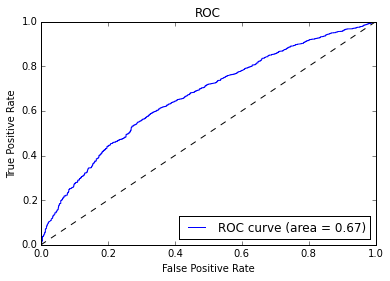

In [26]:
fpr, tpr, thresholds = roc_curve(mat_rep[:,0], mat_rep[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
savefig("ROC.png")

Not bad at all, we have a nice ROC curve and we predict relatively well the popular tunes __Let's try to make our model better__

### 2. Several cross-validations

We will first use the function __KFold__ in scikit in order to do 5 cross-validations and train our model on them. 5 times was empirically a good choice, improving performances without losing speed or precision.

In [35]:
from sklearn.cross_validation import KFold

clf2 = Pipeline([
      ('normalize', Normalizer()),
      ('classification', GradientBoostingClassifier(random_state = 1))
    ])
kf = KFold(7260, n_folds=5, random_state=1)
scores = []
for train, test in kf:
    train_predictors = (X.iloc[train,:])
    train_target = Y.iloc[train]
    # Training the algorithm using the predictors and target.
    clf2.fit(train_predictors, train_target)
    scores.append(clf2.score(X.iloc[test,:],Y.iloc[test]))

In [61]:
sum(scores)/5

0.7206611570247935

A 0.72 f1-score is really satisfying. But knowing that we are trying to predict extreme values let's use a __logarithmic transformation__.

# V. Logarithmic transformation and Classification
## 1. Basic Classification

Let's look at our transformed data, we now really have two different groups, let's try to identify them !

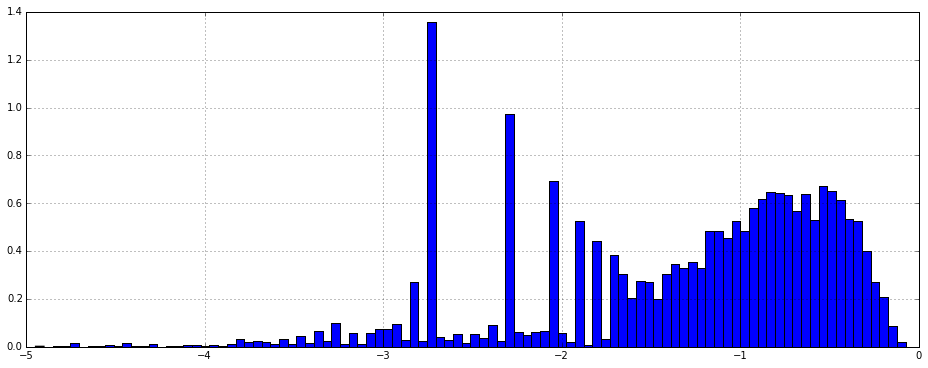

In [27]:
Yl.hist(figsize=(16,6), bins=100, normed = True)
savefig("histo2.png")

In [28]:
Y2 = Yl.apply(lambda r : 1.0 if r > Yl.median() else 0.0 )


In [29]:
from sklearn.cross_validation import train_test_split, cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(X, Y2, test_size=0.4, random_state = 1)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier
clf3 = Pipeline([
      ('normalize', Normalizer()),
      ('classification', GradientBoostingClassifier(random_state = 1))
    ])
clf3 = clf.fit(X_train, Y_train.ravel())

In [36]:
clf3.score(X_test,Y_test)

0.72487277353689572

Not bad at all it is even better than what we had with the KFold setup !

[[1808  529]
 [ 485 1894]]
[[1183  417]
 [ 371 1173]]


C:\Users\Enguérand\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


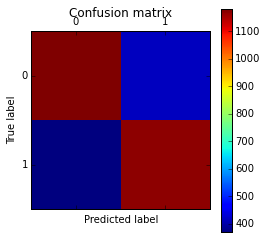

In [48]:
from sklearn.metrics import confusion_matrix
for x,y in [ (X_train, Y_train), (X_test, Y_test) ]:
    yp  = clf3.predict(x)
    cm = confusion_matrix(y.ravel(), yp.ravel())
    print(cm)
import matplotlib.pyplot as plt
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
savefig("conf_mat2.png")

In [38]:
clf4 = Pipeline([
      ('normalize', Normalizer()),
      ('classification', GradientBoostingClassifier(random_state = 1))
    ])
kf = KFold(7260, n_folds=5, random_state=1)
scores2 = []
for train, test in kf:
    train_predictors = (X.iloc[train,:])
    train_target = Y.iloc[train]
    # Training the algorithm using the predictors and target.
    clf4.fit(train_predictors, train_target)
    scores2.append(clf4.score(X.iloc[test,:],Y.iloc[test]))
mean(scores2)

0.7206611570247935

Not that satisfying but we can understand that the first cut we did with the logarithmic model was perfect for our model, we still get a better precision though !

## 2. Let's ROCK !

Our results are quite interesting but there are methods in Scikit to improve performance of estimators by combining them ! Indeed __Voting Classifier__s are used when you got a set of estimators with equal performances. Let's see that not only we have similar results with __Naive Bayes, Logistic Regression, Random Forest and Gradient Boosting Classifier__ but also we can improve our cross validation score by mixing these classifiers together. In order to improve our results even more and cancel overfitting effects we will also use __Grid Search__ to scale hyperparameters of Logistic Regression and Naive Bayes (the two least performant estimators we tested so far). 

In [39]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier , RandomForestClassifier , GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('gbc', clf4)], voting='hard')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(X_train, Y_train.ravel())

for clf, label in zip([clf1, clf2, clf3,clf4, grid], ['Logistic Regression', 'Random Forest', 'naive Bayes','GradientBoostingRegressor', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, X_test, Y_test , cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.73 (+/- 0.02) [Logistic Regression]
Accuracy: 0.72 (+/- 0.02) [Random Forest]
Accuracy: 0.72 (+/- 0.01) [naive Bayes]
Accuracy: 0.73 (+/- 0.01) [GradientBoostingRegressor]
Accuracy: 0.75 (+/- 0.02) [Ensemble]


75 % accuracy !! we started with a poorly optimized regression then choose to consider a classification problem instead. When confronted to limited results we tried transforming our data then mixing estimators and scaling hyperparameters. We could probably use other methods but we will rapidly be limited by the size of our dataset.

We were able to predict a song popularity using only musical parameters. Even though we could not estimate hotttnesss like a regression parameter, thus making it impossible for me to create a 0.645233551 in popularity song we were able to get nice results when we change our perspective. If being good is being better than average, then we can now estimate the parameters of a good song.

![alt text](https://upload.wikimedia.org/wikipedia/commons/9/95/Dominant_seventh_tritone_resolution.png "Logo Title Text 1")

In [44]:
from sklearn.mixture import GMM

gauss = GMM(n_components = 1)
gauss = gauss.fit(Y2)

ValueError: GMM expects at least 2 samples provided in a 2 dimensional array-like input